<a href="https://colab.research.google.com/github/yeshengw/robust-risk-aware-rl/blob/uploads/Example_3_Robust_Dynamic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import sys

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/gdrive


In [2]:
from parameters import *
from market_models import *
from solution import *
from metrics import *
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
print(device)   

cuda


# Networks

In [4]:
class InnerNet(nn.Module):
    
    def __init__(self, n_hidden):
        super(InnerNet, self).__init__()

        self.fc_inp_h1 = nn.Linear(1, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, 1)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.fc_h2_out(x)      
      
        return y

class OuterNet(nn.Module):
    
    def __init__(self, n_feats, n_hidden, n_assets, invent_limit = 5):
        super(OuterNet, self).__init__()
        self.fc_inp_to_h1 = nn.Linear(n_feats, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_out = nn.Linear(n_hidden, n_assets)
        self.invent_limit = invent_limit
        self.myReLU = nn.ReLU()
        self.myTanh = nn.Tanh()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_to_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        y = self.invent_limit * self.myTanh(self.fc_h2_out(x))      
        
        return y

# Agents

In [5]:
class OU_Agent(Agent):
  def __init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update = True):
    Agent.__init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update)
    _, _, Nsims, Nassets, _, _, _ = self.sim_params.GetParams()
    self.X_phi_history = np.empty((Nsims, 0))

  def sim_phi(self):
    t, S = self.market_model.t, self.market_model.S
    Ndt, T, Nsims, Nassets, S0, _, _ = self.sim_params.GetParams()
    S_t = torch.FloatTensor(S).to(device) 
    # asset price change every dt
    S_dt = S_t[1:, :, :] - S_t[:-1, :, :]
    # construct state tensor consisting of time and scaled asset price
    state = torch.zeros((Ndt + 1, Nsims, 2)).to(device)
    state[:, :, 0] = torch.FloatTensor(t.reshape(-1,1) / t[-1]).to(device)
    # asset price scaled in terms of % difference from starting price multiplied by constant of 4 to ensure magnitude is not too small
    state[:, :, 1] = (S_t[:, :, 0] - S0[0]) / S0[0] * 4
    # inventory
    q_t = self.outer_net(state)
    # terminal inventory loss
    self.other_loss = torch.mean(q_t[-1, :, 0] ** 2)
    # sum through time for wealth process according to eqn 2.3 in paper
    X_phi_T = torch.sum(q_t[:-1, :, :] * S_dt, axis = 0)
    X_phi_T_np = X_phi_T.cpu().detach().numpy()
    # initialize array of shares bought/sold at trading times
    phi_t_np = np.zeros((Ndt + 1, Nsims, Nassets))
    # trade size is difference in inventory (initial inventory of 0)
    q_t_np = q_t.cpu().detach().numpy()
    phi_t_np[0, :, 0] = q_t_np[0, :, 0]
    phi_t_np[1:, :, 0] = q_t_np[1:, :, 0] - q_t_np[:-1, :, 0] 
    self.X_phi_history = np.concatenate((self.X_phi_history, X_phi_T_np), axis = 1)
    return X_phi_T

  def PlotCustom(self, X, Y, adversary):
    print("Outer Problem Metrics")
    if self.X_phi_history.shape[1] > 1:
      self.PlotHistory()
    self.PlotStrategy()
    print("Inner Problem Metrics")
    adversary.PrintMetrics()
    adversary.PlotHistory()
    adversary.PlotDistortion(X, Y)
    

  def PlotStrategy(self):
    # plot heatmaps at four quartiles
    Ndt, _, _, _, S0, _, _ = self.sim_params.GetParams()
    quartile_ind = np.linspace(1 , Ndt, 5, dtype = int)
    quartile_names = [r"1st Q End", r"2nd Q End", r"3rd Q End", r"4th Q End"]
    
    # construct meshgrid for heatmap
    t_hm = quartile_ind[1:]/Ndt
    S_hm = np.linspace(0.75, 1.25, 25)
    q_hm = np.linspace(-5, 5, 25)
    t_mesh, S_mesh = np.meshgrid(t_hm, S_hm)
    q_mesh, _ = np.meshgrid(q_hm, S_hm)

    # construct state tensor consisting of time and scaled asset price
    S_feat = (S_mesh - S0[0])/S0[0] * 4
    state = np.dstack((t_mesh, S_feat))
    state_tensor = torch.FloatTensor(state).to(self.device)
    q_tar = self.outer_net(state_tensor).cpu().detach().numpy()

    
    fig = plt.figure(figsize = (5 * 2, 5 * 2))
    for i in range(4):
      # the target trade size is the difference between target inventory and currently held inventory
      trade_hm = q_tar[:, i] - q_mesh
      ax = fig.add_subplot(2, 2, i + 1)
      data_hm = pd.DataFrame(data = trade_hm, index = S_hm.squeeze().round(2), columns = q_hm.squeeze().round(2))
      sns.heatmap(data_hm, vmin = -10, vmax = 10, cbar_kws=dict(label = r'$\phi_t$',  ticks=[-10, -5, 0, 5, 10]), cmap = cm.coolwarm_r , xticklabels = 6, yticklabels = 12)
      ax.set_xlabel(r'$q_t$')
      ax.set_ylabel(r'$S_t$')
      ax.set_title(quartile_names[i], pad = 10)
      ax.invert_yaxis()
      ax.collections[0].colorbar.set_label(r'$\phi_t$', rotation = 270, labelpad = 10)

    plt.tight_layout()
    plt.show()
      

In [6]:
class OU_Adversary(Adversary):
  def __init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective = "maximize", reset_lm = True, reset_net = False):
    Adversary.__init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective, reset_lm, reset_net)

  def sim_theta(self, X_phi_T, market_model):
    X_theta_T = self.inner_net(X_phi_T)
    return X_theta_T



# Parameters

In [7]:
sim_param_dict = { 
               "Nassets" : 1,
               "Nsims" : 5000,
               "S0" : np.array([1]),
               "T" : 1,
               "Ndt" : 252
                }

OU_param_dict = { 
              "kappa" : np.array([5]),
               "sigma" : np.array([0.8]) ,
               "theta" : np.array([1])

                 }
LM_param_dict = { "lam": 1,
                  "mu": 80,
                  "mu_update": 1.2,
                  "update_freq": 1000
                  }


wass_param_dict = {"wass_order" : 2,
                   "wass_limit" : 0.15
                  }

train_param_dict = {"inner_epochs" : 5000,
                    "outer_epochs" : 250,
                    "plot_freq_outer" : 249,
                    "plot_freq_inner" : np.inf,
                    "inner_lr": 1e-3,
                    "outer_lr": 2e-2,
                    "freeze_market_iter": 1,
                    "freeze_inner_iter" : 1
                   }

sim_params = Sim_Params(sim_param_dict)
market_params = MarketModel_Params(OU_param_dict, Type = "OU")
lm_params = LM_Params(LM_param_dict)
wass_params = Wass_Params(wass_param_dict)
train_params = Train_Params(train_param_dict)

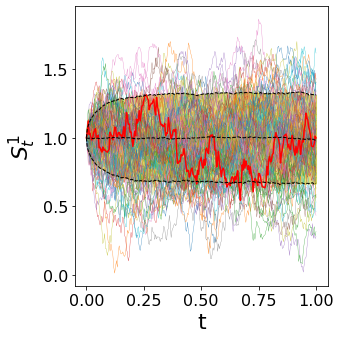

In [8]:
OU_model = Ornstein_Uhlenbeck(market_params)
OU_model.Sim(sim_params)
OU_model.PlotSim()


# Results

## $\alpha = 0.1, \beta = 0.9, p = 0.75$

In [10]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.75,
                  "rm_type" : 'alpha-beta'
                  }
                  
rm_params = RM_Params(RM_param_dict)

In [11]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(2, 10, 1).to(device)
inner_name = root_dir + "inner_p_0.75"
outer_name = root_dir + "outer_p_0.75"

Outer Epoch: 0 Outer Iter: 0
Outer Problem Metrics


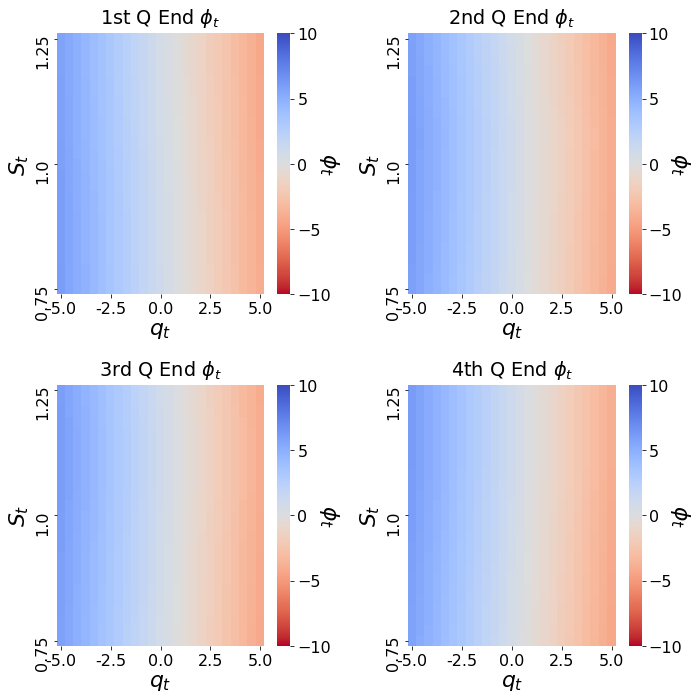

Inner Problem Metrics
Wass Dist History:  [0.15096479654312134, 0.15099972486495972, 0.15059354901313782, 0.1498323231935501, 0.1506079137325287]
Risk Measure X_theta History:  [0.5878922939300537, 0.5879645943641663, 0.5870065689086914, 0.5851871967315674, 0.5870394706726074]
Loss History:  [0.1433764100074768, 0.1425931602716446, 0.1400454342365265, -0.5874837040901184, 0.1398468166589737]
Augmented Lagrangian lambda: 10.048100966644292 mu: 199.06559999999996


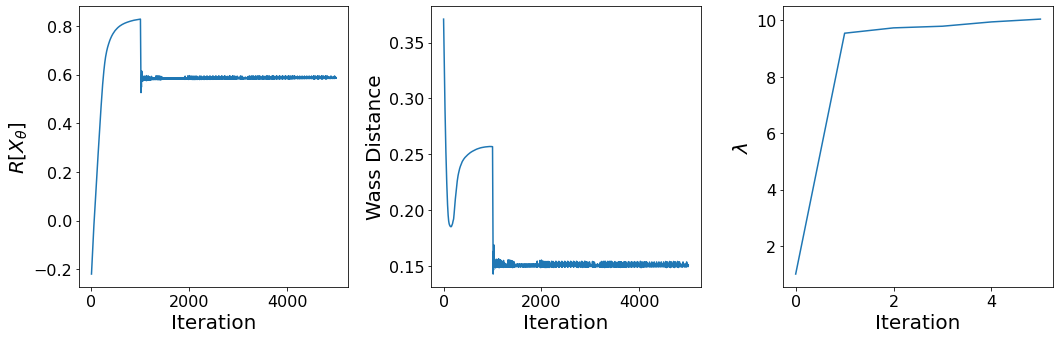

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


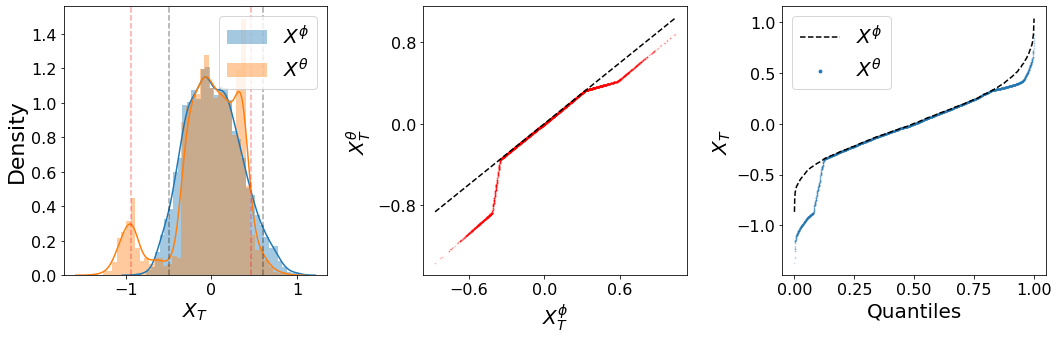

Outer Epoch: 349 Outer Iter: 0
Outer Problem Metrics


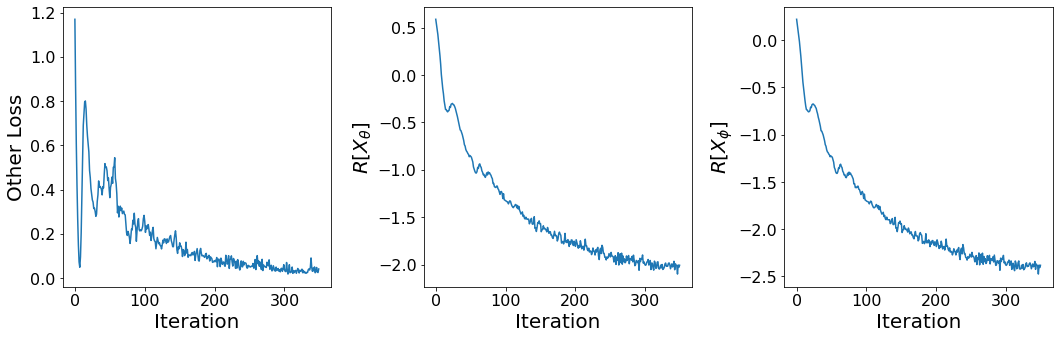

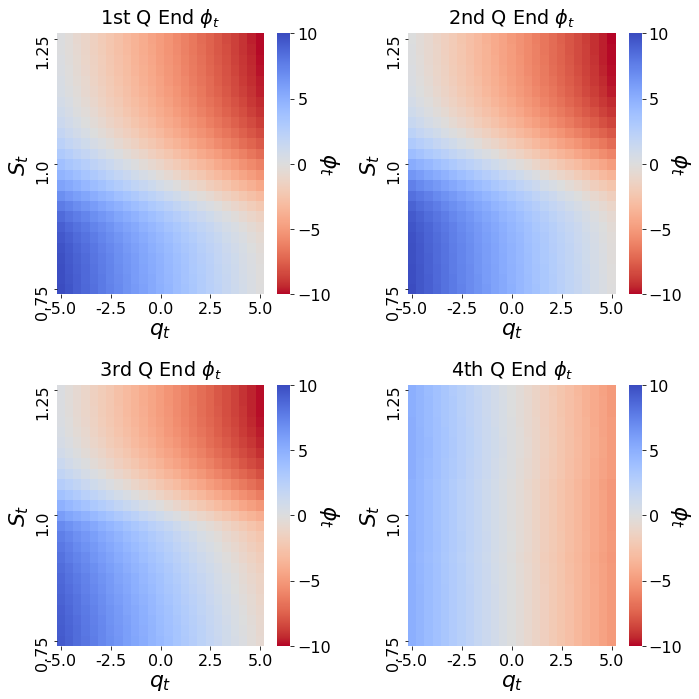

Inner Problem Metrics
Wass Dist History:  [0.15077786147594452, 0.15136277675628662, 0.1515999138355255, 0.15145350992679596, 0.15096181631088257]
Risk Measure X_theta History:  [-2.005837917327881, -2.0043892860412598, -2.0038492679595947, -2.0042190551757812, -2.005403757095337]
Loss History:  [-0.4024525284767151, -0.6438993215560913, -0.7680151462554932, -0.7668370008468628, -0.653161346912384]
Augmented Lagrangian lambda: 10.617422364807133 mu: 199.06559999999996


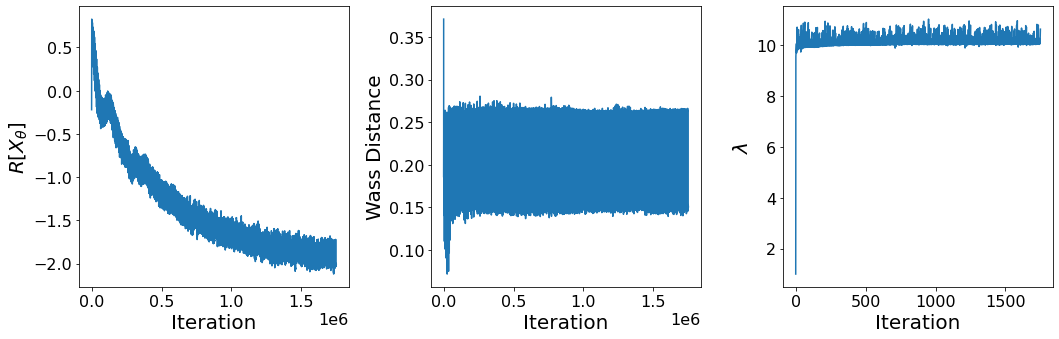

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


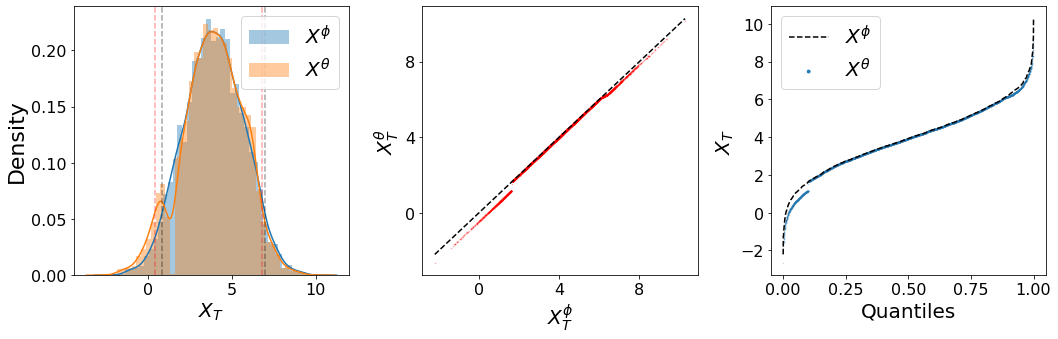

OuterNet(
  (fc_inp_to_h1): Linear(in_features=2, out_features=10, bias=True)
  (fc_h1_h2): Linear(in_features=10, out_features=10, bias=True)
  (fc_h2_out): Linear(in_features=10, out_features=1, bias=True)
  (myReLU): ReLU()
  (myTanh): Tanh()
)

In [12]:
agent = OU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

## $\alpha = 0.1, \beta = 0.9, p = 0.9$

In [9]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 0.9,
                  "rm_type" : 'alpha-beta'
                  }
                  
rm_params = RM_Params(RM_param_dict)

In [10]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(2, 10, 1).to(device)
inner_name = root_dir + "inner_p_0.9"
outer_name = root_dir + "outer_p_0.9"

Outer Epoch: 0 Outer Iter: 0
Outer Problem Metrics


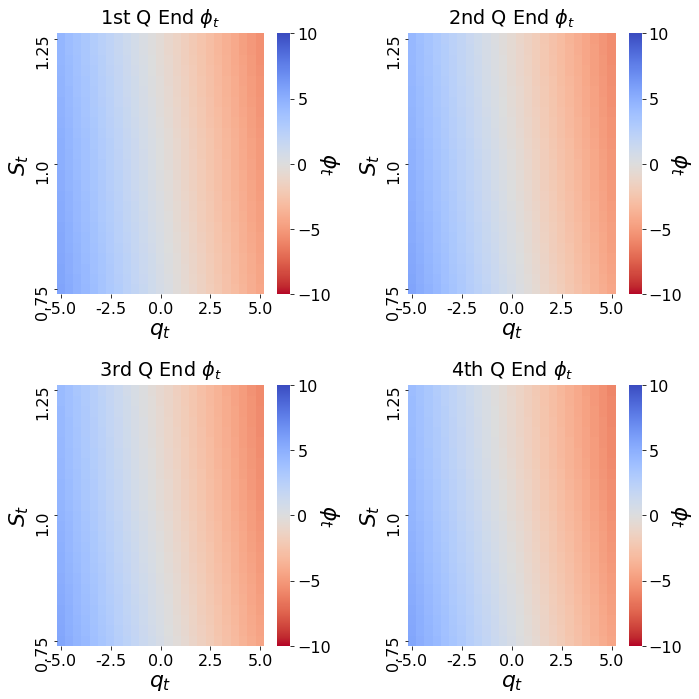

Inner Problem Metrics
Wass Dist History:  [0.15116754174232483, 0.15094010531902313, 0.15055453777313232, 0.1500547230243683, 0.14947815239429474]
Risk Measure X_theta History:  [0.03485150635242462, 0.034237056970596313, 0.033175431191921234, 0.031776316463947296, 0.030147898942232132]
Loss History:  [-0.01933693140745163, -0.007820663042366505, 0.008796053938567638, 0.026796510443091393, -0.03049307130277157]
Augmented Lagrangian lambda: 10.494869658660892 mu: 199.06559999999996


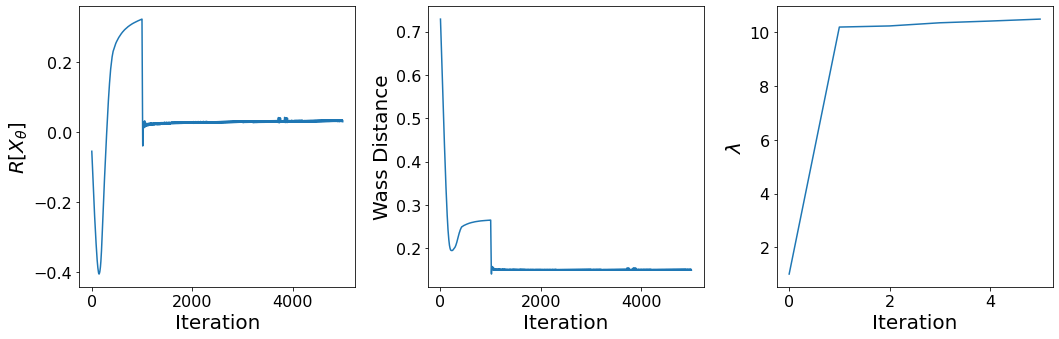

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


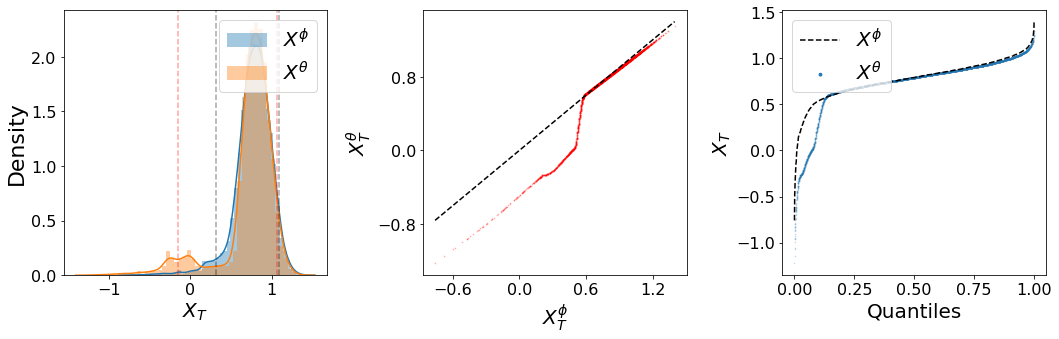

Outer Epoch: 249 Outer Iter: 0
Outer Problem Metrics


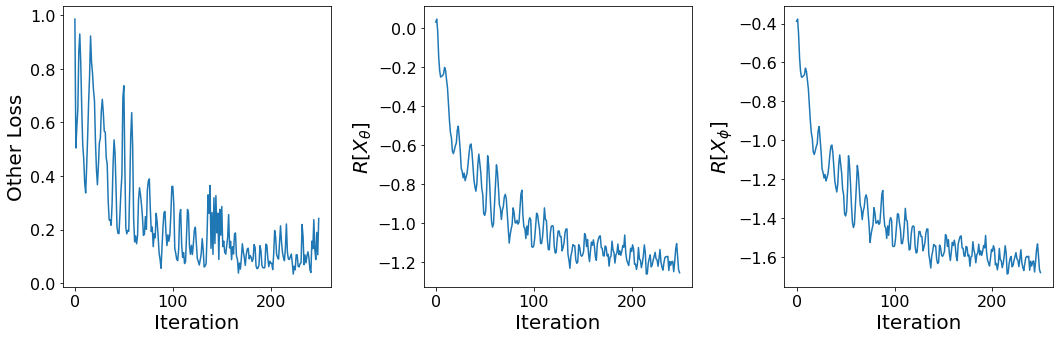

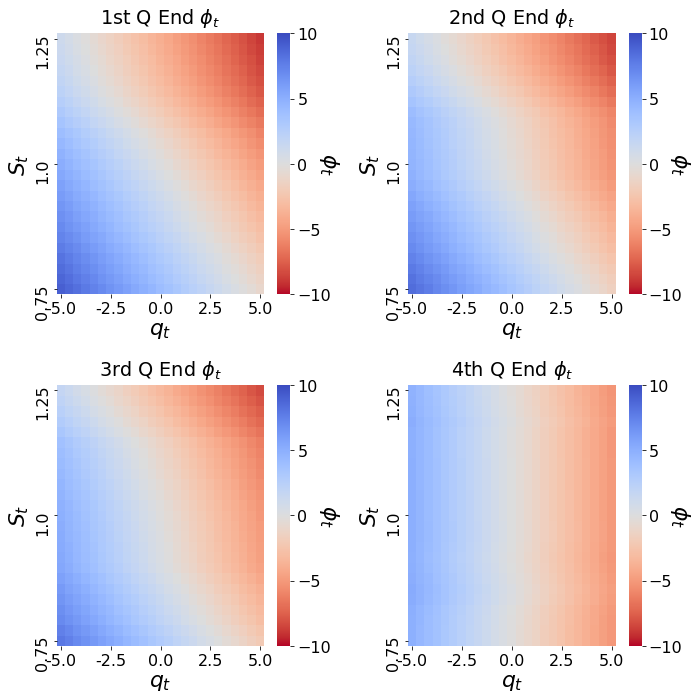

Inner Problem Metrics
Wass Dist History:  [0.15050363540649414, 0.15089796483516693, 0.15102165937423706, 0.15081878006458282, 0.15043790638446808]
Risk Measure X_theta History:  [-1.2519431114196777, -1.2508604526519775, -1.2505595684051514, -1.251071810722351, -1.2521291971206665]
Loss History:  [-0.15600207448005676, -0.2541361153125763, -0.28848031163215637, -0.2494281679391861, -0.16540202498435974]
Augmented Lagrangian lambda: 11.325224922943118 mu: 199.06559999999996


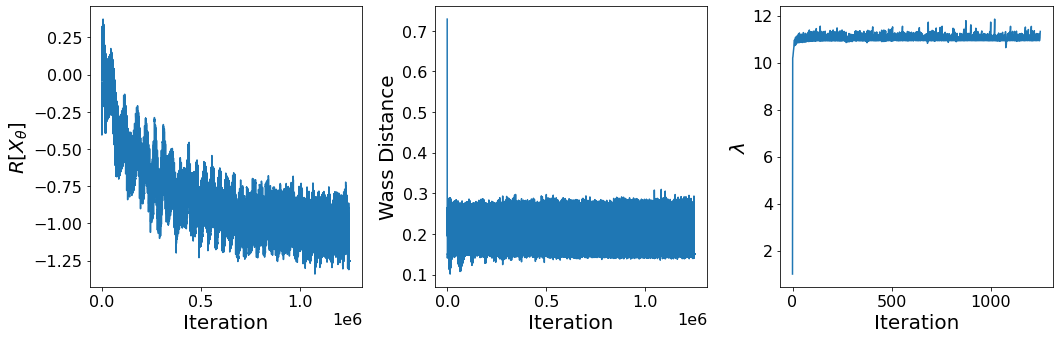

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


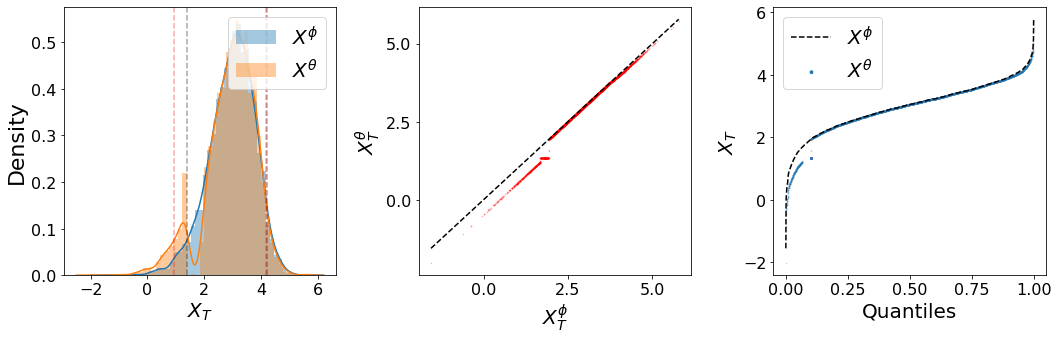

OuterNet(
  (fc_inp_to_h1): Linear(in_features=2, out_features=10, bias=True)
  (fc_h1_h2): Linear(in_features=10, out_features=10, bias=True)
  (fc_h2_out): Linear(in_features=10, out_features=1, bias=True)
  (myReLU): ReLU()
  (myTanh): Tanh()
)

In [11]:
agent = OU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)

## $\alpha = 0.1, \beta = 0.9, p = 1$

In [12]:
RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                   "p" : 1,
                  "rm_type" : 'alpha-beta'
                  }
                  
rm_params = RM_Params(RM_param_dict)

In [13]:
inner_net = InnerNet(10).to(device)
outer_net = OuterNet(2, 10, 1).to(device)
inner_name = root_dir + "inner_p_1"
outer_name = root_dir + "outer_p_1"

Outer Epoch: 0 Outer Iter: 0
Outer Problem Metrics


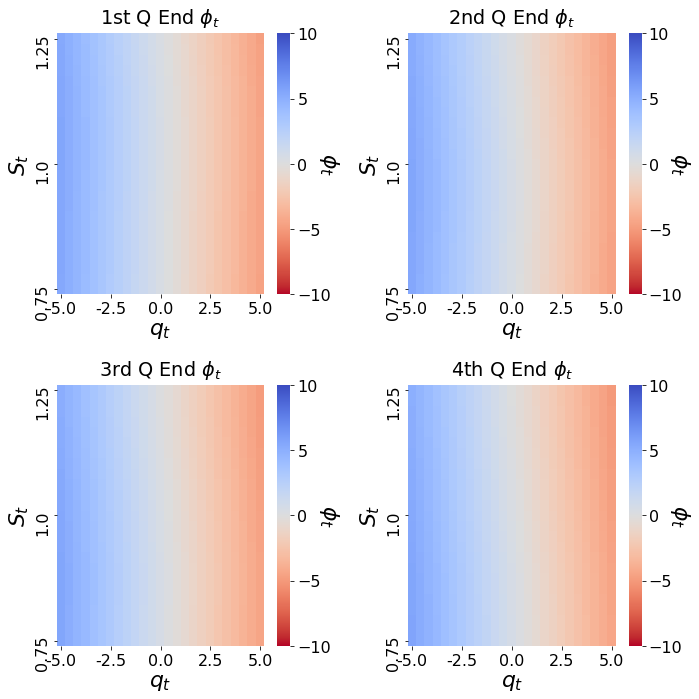

Inner Problem Metrics
Wass Dist History:  [0.1527787446975708, 0.15264303982257843, 0.1522071659564972, 0.15177591145038605, 0.15133431553840637]
Risk Measure X_theta History:  [0.9889166951179504, 0.9888723492622375, 0.9877327680587769, 0.986064612865448, 0.9843608140945435]
Loss History:  [0.135017529129982, 0.13561667501926422, 0.13372604548931122, 0.1312268078327179, 0.12648023664951324]
Augmented Lagrangian lambda: 11.871217744445804 mu: 199.06559999999996


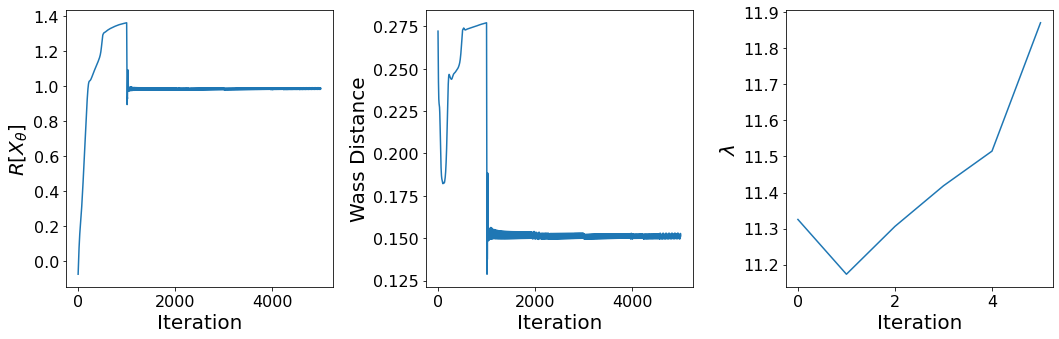

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


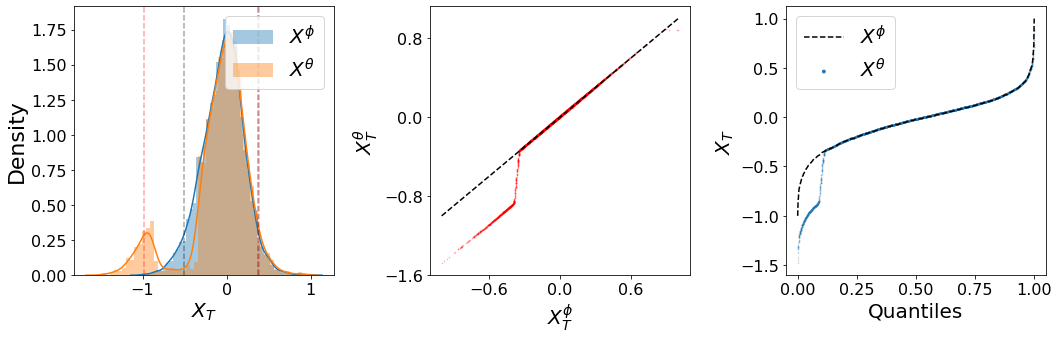

Outer Epoch: 249 Outer Iter: 0
Outer Problem Metrics


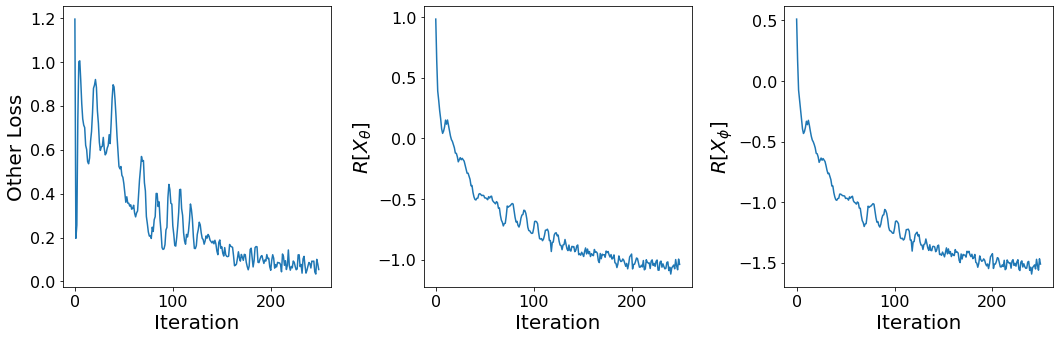

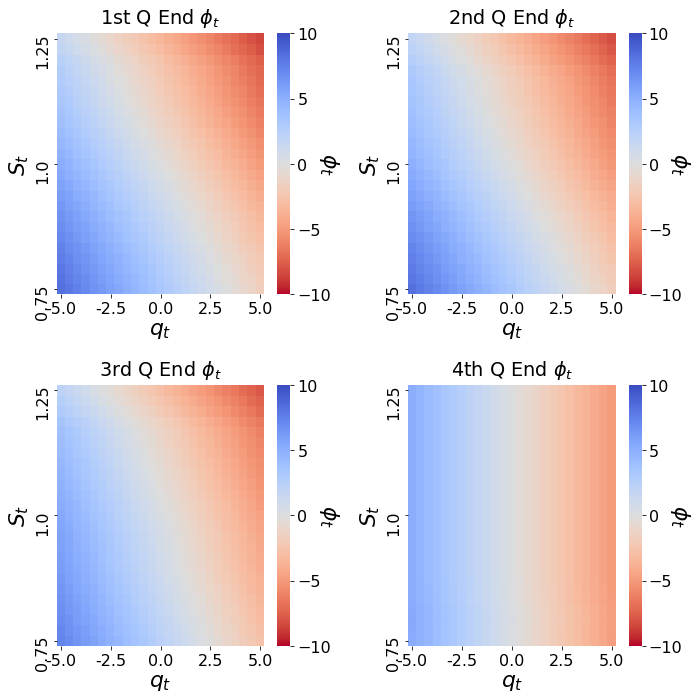

Inner Problem Metrics
Wass Dist History:  [0.15090149641036987, 0.15063339471817017, 0.15003763139247894, 0.15110333263874054, 0.14985345304012299]
Risk Measure X_theta History:  [-1.0403850078582764, -1.0411428213119507, -1.0406761169433594, -1.0400632619857788, -1.0413213968276978]
Loss History:  [-1.188156247138977, 0.9159066081047058, 0.22411185503005981, -1.2501022815704346, 1.0439469814300537]
Augmented Lagrangian lambda: 11.831187944030765 mu: 199.06559999999996


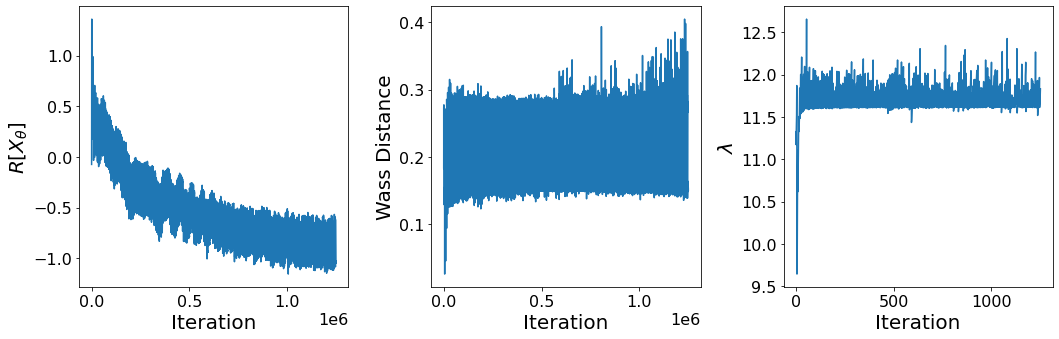

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


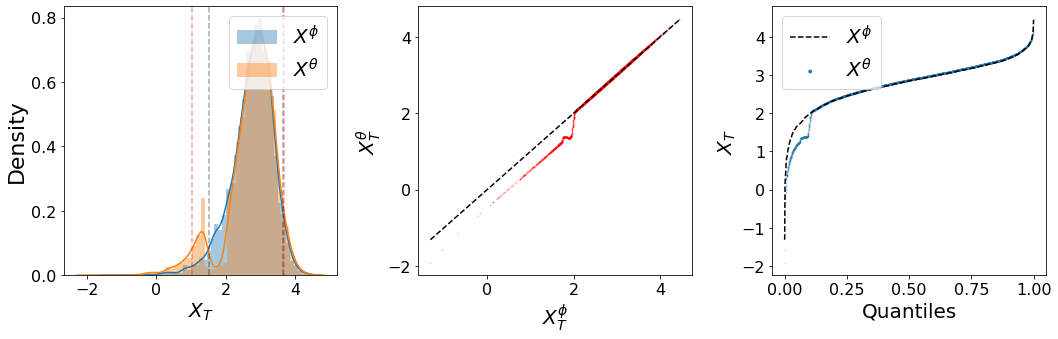

OuterNet(
  (fc_inp_to_h1): Linear(in_features=2, out_features=10, bias=True)
  (fc_h1_h2): Linear(in_features=10, out_features=10, bias=True)
  (fc_h2_out): Linear(in_features=10, out_features=1, bias=True)
  (myReLU): ReLU()
  (myTanh): Tanh()
)

In [14]:
agent = OU_Agent(OU_model, sim_params, train_params, device, outer_net, outer_name)
adversary = OU_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)